In [509]:
import PIL
import cv2
from matplotlib import pyplot as plt
import multiprocessing
from functools import partial
import shutil
import itertools
import collections
import os
import numpy as np
from pdb import set_trace
%matplotlib inline
from sklearn.decomposition import PCA as sklearnPCA
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils
import dlib
import uuid
import pandas as pd
import networkx as nx
from scipy.spatial import distance

In [2]:
path = 'data/msan-images/'

In [3]:
stu_fn = !ls {path}/students

In [4]:
fc_fn = !ls {path}/faculty

In [5]:
img = cv2.imread(path + 'faculty/' + fc_fn[0])
print(img.shape)

(500, 500, 3)


In [6]:
img = cv2.imread(path + 'students/' + stu_fn[0])
print(img.shape)

(150, 150, 3)


Images are of different sizes in both the groups. Student image is ***150x150*** and faculty image is ***500x500***

### Visualizing the images

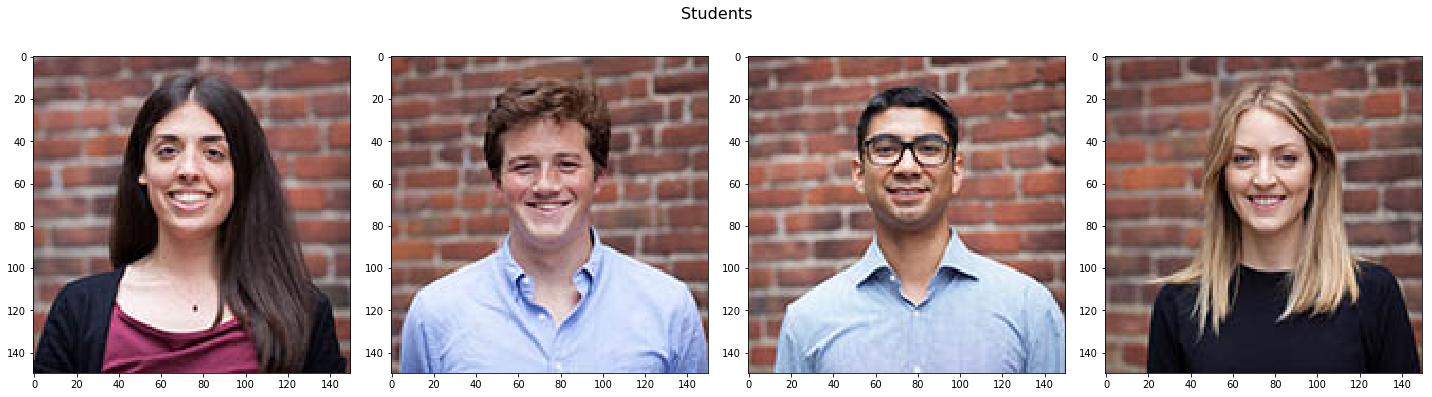

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
for i in range(4):
    img = cv2.imread(path + 'students/' + stu_fn[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
plt.suptitle('Students', fontsize=16)
plt.tight_layout()

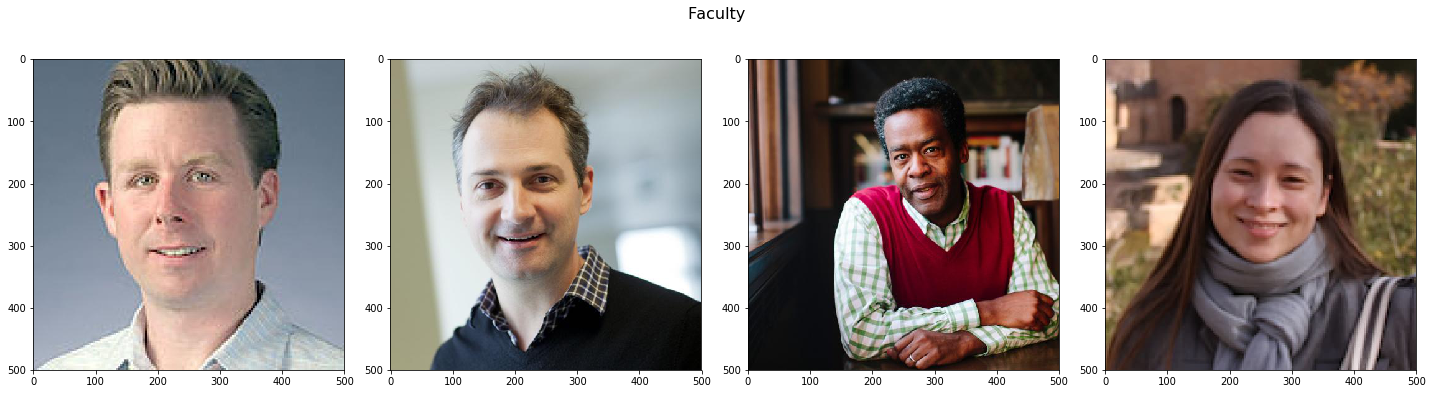

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
for i in range(4):
    img = cv2.imread(path + 'faculty/' + fc_fn[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
plt.suptitle('Faculty', fontsize=16)
plt.tight_layout()

### Resizing faculty images

Resizing the faculty images to 150x150

In [9]:
# This function loads a file, resize it and write in the output folder
def img_resize(fname, outdir, sz, in_dir):
    '''
    fname: image filename
    outdir: relative path to output directory
    sz: final size of image
    in_dir: relative path to the input directory
    '''
    os.makedirs(outdir, exist_ok=True)
    im = cv2.imread(in_dir + fname)
    small_im = cv2.resize(im, (sz, sz))
    cv2.imwrite(outdir + fname, small_im)


def parallel_runs(data_list, outdir, in_dir, sz=300, process=4):
    '''
    data_list: list of filenames of images stores in a list
    outdir: relative path to output directory
    sz: final size of image
    in_dir: relative path to the input directory
    process: num of threads in your cpu
    '''
    pool = multiprocessing.Pool(processes=process)
    img_resize_x = partial(img_resize, outdir=outdir, sz=sz, in_dir=in_dir)
    pool.map(img_resize_x, data_list)
# inputdir = 'data/msan-images/faculty/'

# filelist = !ls {inputdir}

# outdir = 'data/msan-images/faculty-resized/'

# parallel_runs(filelist,outdir,inputdir,150,4)

Visualizing after resizing images

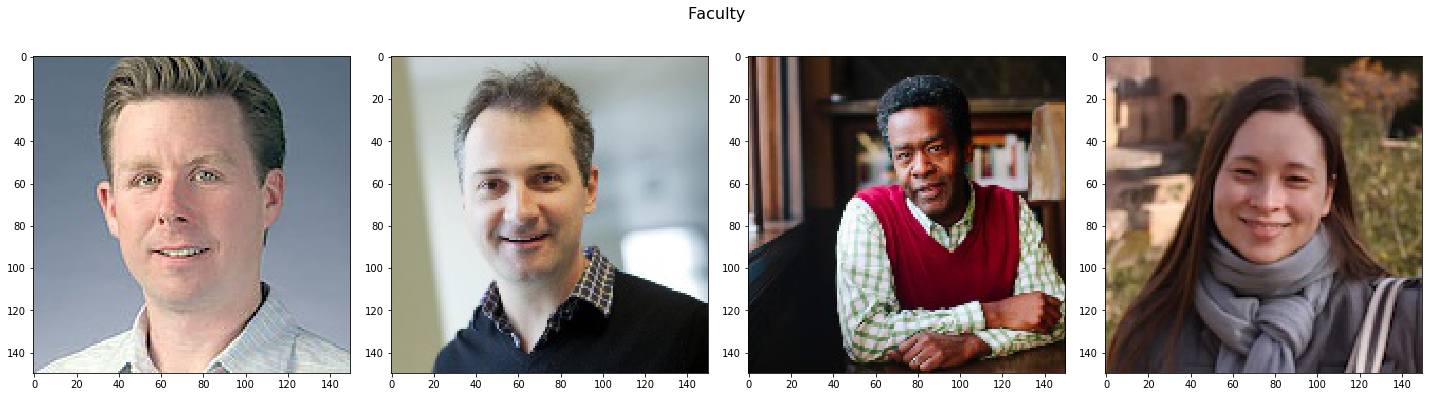

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
for i in range(4):
    img = cv2.imread(path + 'faculty-resized/' + fc_fn[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
plt.suptitle('Faculty', fontsize=16)
plt.tight_layout()

## Student Version

### Cropping faces from the image

Source: http://gregblogs.com/computer-vision-cropping-faces-from-images-using-opencv2/

In [55]:
def facechop(input_dir, fnames, output_dir):
    '''
    Extract faces from the images present in the input directory and save the cropped images in the output directory
    input:
    input_dir: path to the directory where the input images are present
    fnames: list of filenames in the input_dir for which face extraction needs to be done
    output_dir: path to the directory where the output images need to be saved
    
    return: None
    Note: 
    Output may or may not be of the same size
    There can be multiple version of cropped image. Pick the best crop
    '''
    os.makedirs(output_dir, exist_ok=True)

    facedata = "haarcascade_frontalface_default.xml"

    for fn in fnames:
        cascade = cv2.CascadeClassifier(facedata)
        img = cv2.imread(input_dir + fn)
        face = cascade.detectMultiScale(img)
        faces = []
        for i, f in enumerate(face):
            x, y, w, h = f
            sub_face = img[y:y + h, x:x + w]
            cv2.imwrite(output_dir + str(i) + "_" + fn, sub_face)
    return None

In [56]:
#extracting face from the whole image
facechop('data/msan-images/students/',stu_fn,'data/msan-images/students-faces/')

As the output of the above function has variable image size, we need to resize them to a consistent size for PCA

In [59]:
# done

sz = 50

inputdir = 'data/msan-images/students-faces/'

filelist = !ls {inputdir}

outdir = 'data/msan-images/students-faces-resized/'

parallel_runs(filelist,outdir,inputdir,sz,4)

### Eigen faces

**Step1**: Prepare a training set of face images. The pictures constituting the training set should have been taken under the same lighting conditions, and must be normalized to have the eyes and mouths aligned across all images. They must also be all resampled to a common pixel resolution (r × c). Each image is treated as one vector, simply by concatenating the rows of pixels in the original image, resulting in a single column with r × c elements. For this implementation, it is assumed that all images of the training set are stored in a single matrix T, where each column of the matrix is an image.

In [60]:
def readImages(path, fnames):
    images = []
    for f in fnames:
        imagePath = os.path.join(path, f)
        img = cv2.imread(imagePath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    numImages = len(images)
    return images

In [62]:
# Directory containing face images
dirName = "data/msan-images/students-faces-resized/"

stu_fn1 = !ls {path}/students-faces-resized/
# Read images
images = readImages(dirName, stu_fn1)

In [91]:
len(images) #75 students

75

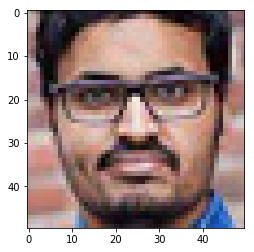

In [98]:
plt.imshow(images[40])

In [93]:
images_gray = [
    np.stack(
        (cv2.cvtColor(i, cv2.COLOR_RGB2GRAY),
         cv2.cvtColor(i, cv2.COLOR_RGB2GRAY),
         cv2.cvtColor(i, cv2.COLOR_RGB2GRAY)),
        axis=-1) for i in images
]

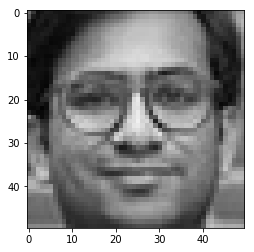

In [99]:
plt.imshow(images_gray[50])

In [100]:
def createDataMatrix(images):
    numImages = len(images)
    sz = images[0].shape
    data = np.zeros((numImages, sz[0] * sz[1] * sz[2]), dtype=np.float32)
    for i in range(0, numImages):
        image = images[i].flatten()
        data[i, :] = image
    print("DONE")
    return data

In [101]:
# Create data matrix for PCA.
data_color = createDataMatrix(images)

DONE


In [102]:
data_gray = createDataMatrix(images_gray)

DONE


In [106]:
data_color = data_color.T

In [107]:
data_gray = data_gray.T

**Step 2** : Subtract the mean. The average image a has to be calculated and then subtracted from each original image in T.

In [112]:
avg_col_img = np.mean(data_color, axis=1)

In [113]:
avg_gray_img = np.mean(data_gray,axis=1)

In [119]:
data_col_norm = (data_color - avg_col_img.reshape(7500,1))

In [120]:
data_gray_norm = (data_gray - avg_gray_img.reshape(7500,1))

In [132]:
avg_col_img = avg_col_img.reshape(50,50,3)

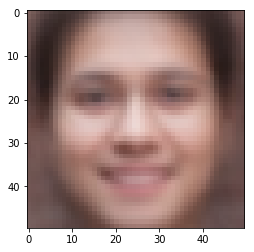

In [137]:
plt.imshow(avg_col_img/255)

In [138]:
avg_gray_img = avg_gray_img.reshape(50,50,3)

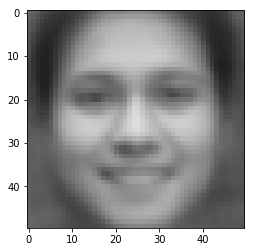

In [139]:
plt.imshow(avg_gray_img/255)

**Step 3** : Calculate the eigenvectors and eigenvalues of the covariance matrix S. Each eigenvector has the same dimensionality (number of components) as the original images, and thus can itself be seen as an image. The eigenvectors of this covariance matrix are therefore called eigenfaces. They are the directions in which the images differ from the mean image. Usually this will be a computationally expensive step (if at all possible), but the practical applicability of eigenfaces stems from the possibility to compute the eigenvectors of S efficiently, without ever computing S explicitly, as detailed below.

In [170]:
pca_col = sklearnPCA()

eigenFaces_col = pca_col.fit_transform(data_col_norm)

eigenValues_col = pca_col.explained_variance_ratio_

In [171]:
eigenFaces_col.shape

(7500, 75)

In [172]:
pca_gray = sklearnPCA()

eigenFaces_gray = pca_gray.fit_transform(data_gray_norm)

eigenFaces_gray.shape

(7500, 75)

In [173]:
eigenFaces_col

array([[-4.6639061e+01,  1.1322618e+02, -1.3388361e+02, ...,
        -2.5750309e+01, -2.7047356e+01,  7.1052644e-05],
       [-5.7653076e+01,  6.7021271e+01, -1.3393620e+02, ...,
        -5.9233165e+00,  9.5470200e+00, -4.5069704e-05],
       [-6.8965881e+01,  6.1247742e+01, -1.1963669e+02, ...,
         2.5118980e+00,  4.9608669e+00, -4.3999698e-05],
       ...,
       [ 3.1079239e+02, -6.9352631e+01, -9.3547874e+01, ...,
         4.9362755e+00,  1.6312231e+01, -2.1339418e-05],
       [ 2.6729019e+02, -2.9423210e+01, -1.0142184e+02, ...,
        -2.8282235e+00,  9.3957911e+00, -2.7094798e-05],
       [ 2.5906686e+02, -2.5780169e+01, -1.0224380e+02, ...,
        -8.4873476e+00,  1.0310207e+01,  2.1506378e-06]], dtype=float32)

In [174]:
eigenFaces_col

array([[-4.6639061e+01,  1.1322618e+02, -1.3388361e+02, ...,
        -2.5750309e+01, -2.7047356e+01,  7.1052644e-05],
       [-5.7653076e+01,  6.7021271e+01, -1.3393620e+02, ...,
        -5.9233165e+00,  9.5470200e+00, -4.5069704e-05],
       [-6.8965881e+01,  6.1247742e+01, -1.1963669e+02, ...,
         2.5118980e+00,  4.9608669e+00, -4.3999698e-05],
       ...,
       [ 3.1079239e+02, -6.9352631e+01, -9.3547874e+01, ...,
         4.9362755e+00,  1.6312231e+01, -2.1339418e-05],
       [ 2.6729019e+02, -2.9423210e+01, -1.0142184e+02, ...,
        -2.8282235e+00,  9.3957911e+00, -2.7094798e-05],
       [ 2.5906686e+02, -2.5780169e+01, -1.0224380e+02, ...,
        -8.4873476e+00,  1.0310207e+01,  2.1506378e-06]], dtype=float32)

In [195]:
def imgNorm(img):
    '''
    input: 
    img: image matrix
    return: img matrix normalized between [0,1] 
    '''
    cmin = img.min()
    cmax = img.max()
    return (img - cmin) / (cmax - cmin)

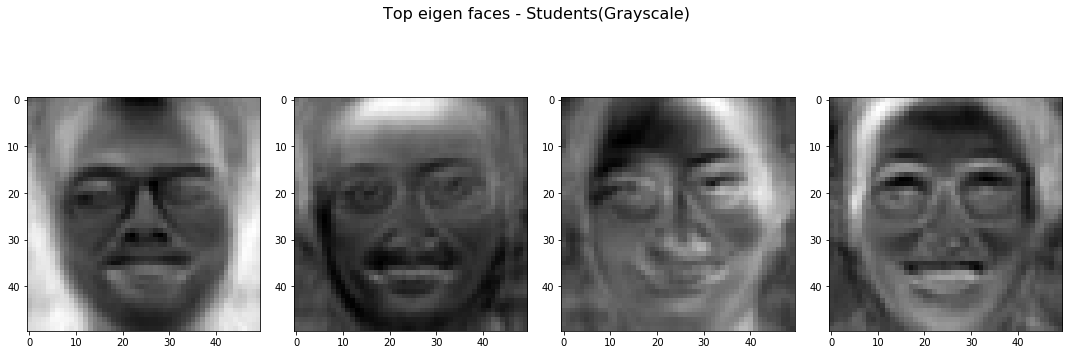

In [202]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6))
for i in range(4):
    axes[i].imshow(imgNorm(eigenFaces_gray[:, i].reshape(50, 50, 3)))
plt.suptitle('Top eigen faces - Students(Grayscale)', fontsize=16)
plt.tight_layout()

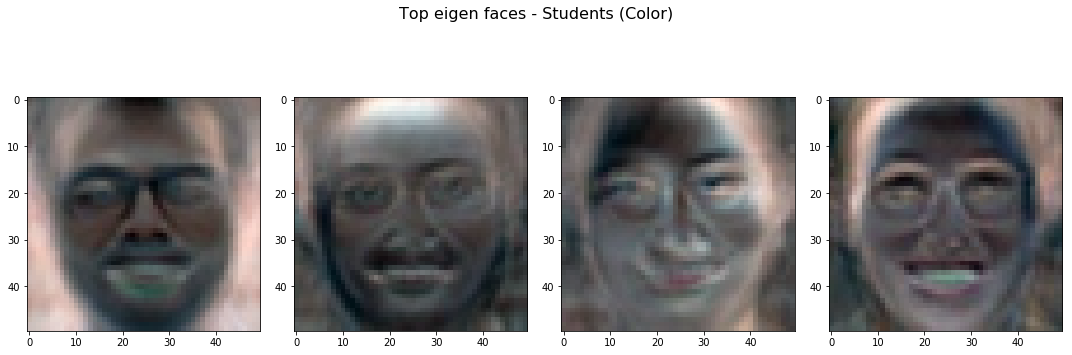

In [353]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6))
for i in range(4):
    axes[i].imshow(imgNorm(eigenFaces_col[:, i].reshape(50, 50, 3)))
plt.suptitle('Top eigen faces - Students (Color)', fontsize=16)
plt.tight_layout()

**Explained variance**

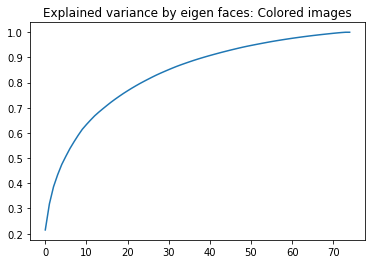

In [208]:
plt.plot(np.cumsum(pca_col.explained_variance_ratio_))
plt.title('Explained variance by eigen faces: Colored images')
plt.show()

In [217]:
print("The first 4 eigen faces explains ",
      str(np.sum(pca_col.explained_variance_ratio_[:4])),
      " of the total variability")

The first 4 eigen faces explains  0.43391624  of the total variability


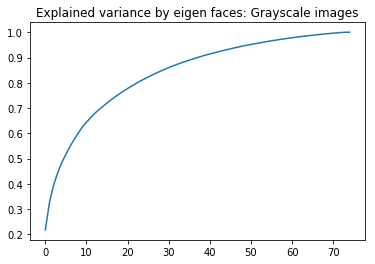

In [215]:
plt.plot(np.cumsum(pca_gray.explained_variance_ratio_))
plt.title('Explained variance by eigen faces: Grayscale images')
plt.show()

In [218]:
print("The first 4 eigen faces explains ",
      str(np.sum(pca_gray.explained_variance_ratio_[:4])),
      " of the total variability")

The first 4 eigen faces explains  0.44270492  of the total variability


**Reconstruction**

In [363]:
myImg = "data/msan-images/students-faces-resized/0_msan-student-gupta-shikhar.jpg"

In [364]:
img = cv2.imread(myImg)

In [365]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

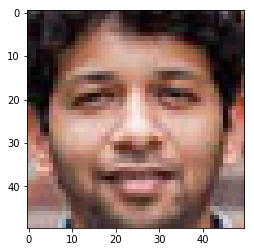

In [366]:
plt.imshow(img)

In [367]:
img_mean_norm = (img.flatten() - avg_col_img.flatten()).reshape(50, 50, 3)

In [368]:
def eigfacesCombination(eigenfaces, targetImg):
    """
    Solve for Ax = b with OLS
    eigenfaces: eigen faces matrix
    targetImg: Image to reconstruct
    w: weights
    """
    w = np.linalg.lstsq(eigenfaces, targetImg.flatten(), rcond=None)[0]
    return w

In [369]:
weights = eigfacesCombination(eigenFaces_col, img_mean_norm)

In [372]:
def imgReconstruct(eigenFaces, weights, numFaces):
    reconstruct = np.zeros((50, 50, 3))
    for i in range(numFaces):
        reconstruct += (eigenFaces[:, i] * weights[i]).reshape(50, 50, 3)
    return reconstruct

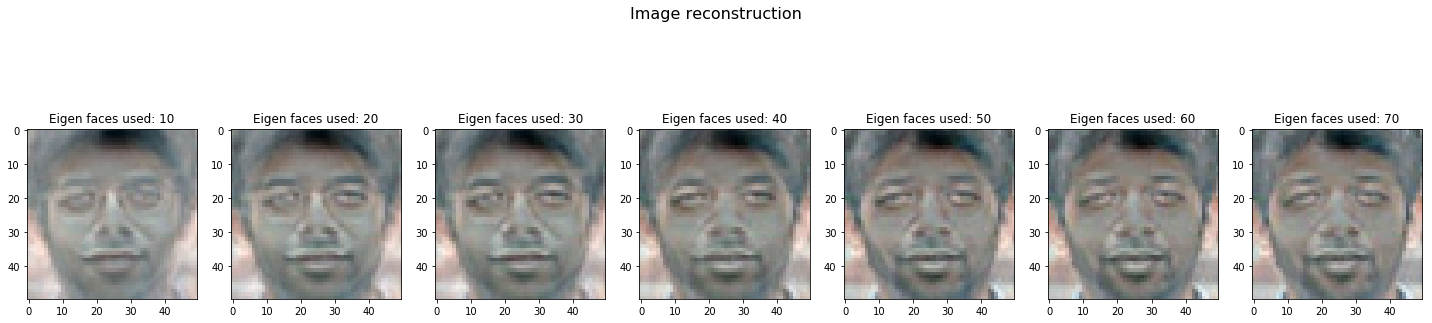

In [405]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20, 6))
for i in range(7):
    axes[i].imshow(
        imgNorm(imgReconstruct(eigenFaces_col, weights, 10 * (i + 1))))
    axes[i].set_title(f"Eigen faces used: {10 * (i + 1)}")
plt.suptitle('Image reconstruction', fontsize=16)
plt.tight_layout()

## Faculty version

### Face alignment

Source: https://www.pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/

In [411]:
shape_predictor_path = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor_path)
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor and the face aligner
fa = FaceAligner(predictor, desiredFaceWidth=50)
os.makedirs("data/msan-images/faculty-faces_aligned/", exist_ok=True)
for fn in fc_fn:
    image_path = f"data/msan-images/faculty-resized/{fn}"
    # load the input image, resize it, and convert it to grayscale
    image = cv2.imread(image_path)
    #     image = imutils.resize(image, width=800)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 2)
    # loop over the face detections
    for i, rect in enumerate(rects):
        # extract the ROI of the *original* face, then align the face
        # using facial landmarks
        (x, y, w, h) = rect_to_bb(rect)
        faceOrig = imutils.resize(image[y:y + h, x:x + w], width=50)
        faceAligned = fa.align(image, gray, rect)
        cv2.imwrite(
            "data/msan-images/faculty-faces_aligned/" + str(i) + "_" + fn,
            faceAligned)

### Eigen faces

In [412]:
# Directory containing face images
dirName = "data/msan-images/faculty-faces_aligned/"

fc_fn = !ls {path}/faculty-faces_aligned/
# Read images
images = readImages(dirName, fc_fn)

In [413]:
len(images) #75 students

15

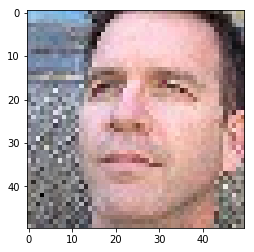

In [414]:
plt.imshow(images[9])

In [415]:
images_gray = [
    np.stack(
        (cv2.cvtColor(i, cv2.COLOR_RGB2GRAY),
         cv2.cvtColor(i, cv2.COLOR_RGB2GRAY),
         cv2.cvtColor(i, cv2.COLOR_RGB2GRAY)),
        axis=-1) for i in images
]

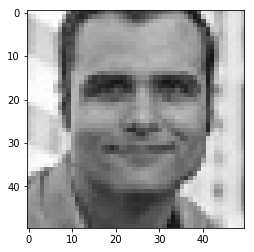

In [416]:
plt.imshow(images_gray[8])

In [419]:
# Create data matrix for PCA.
data_color = createDataMatrix(images)

DONE


In [420]:
data_gray = createDataMatrix(images_gray)

DONE


In [421]:
data_color = data_color.T

In [422]:
data_gray = data_gray.T

**Step 2** : Subtract the mean. The average image a has to be calculated and then subtracted from each original image in T.

In [423]:
avg_col_img = np.mean(data_color, axis=1)

In [424]:
avg_gray_img = np.mean(data_gray,axis=1)

In [425]:
data_col_norm = (data_color - avg_col_img.reshape(7500,1))

In [426]:
data_gray_norm = (data_gray - avg_gray_img.reshape(7500,1))

In [427]:
avg_col_img = avg_col_img.reshape(50,50,3)

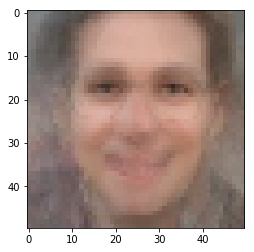

In [428]:
plt.imshow(avg_col_img/255)

In [429]:
avg_gray_img = avg_gray_img.reshape(50,50,3)

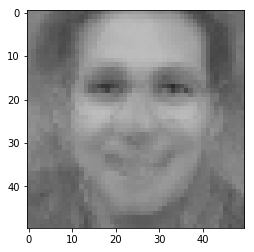

In [430]:
plt.imshow(avg_gray_img/255)

**Step 3** : Calculate the eigenvectors and eigenvalues of the covariance matrix S. Each eigenvector has the same dimensionality (number of components) as the original images, and thus can itself be seen as an image. The eigenvectors of this covariance matrix are therefore called eigenfaces. They are the directions in which the images differ from the mean image. Usually this will be a computationally expensive step (if at all possible), but the practical applicability of eigenfaces stems from the possibility to compute the eigenvectors of S efficiently, without ever computing S explicitly, as detailed below.

In [431]:
pca_col = sklearnPCA()

eigenFaces_col = pca_col.fit_transform(data_col_norm)

eigenValues_col = pca_col.explained_variance_ratio_

In [432]:
eigenFaces_col.shape

(7500, 15)

In [433]:
pca_gray = sklearnPCA()

eigenFaces_gray = pca_gray.fit_transform(data_gray_norm)

eigenFaces_gray.shape

(7500, 15)

In [434]:
eigenFaces_col

array([[ 4.0070286e+00, -1.6881023e+02, -3.3376217e+01, ...,
         3.9667820e+01, -2.3272694e+01,  7.6493179e-06],
       [-1.8771772e+01, -1.6431262e+02, -6.5649857e+01, ...,
        -9.9718084e+00,  6.3570395e+00,  4.3004264e-05],
       [-5.0521076e+01, -1.4702306e+02, -8.3073784e+01, ...,
        -4.3117138e+01,  2.4456770e+01, -3.4617071e-05],
       ...,
       [-9.6008858e+01, -1.2420379e+02,  1.6952837e+02, ...,
        -2.2940823e+01,  7.2587563e+01,  5.6886047e-06],
       [-7.6139923e+01, -1.2962404e+02,  1.5057465e+02, ...,
        -2.7906748e+01,  7.0601631e+01,  7.9642859e-06],
       [-7.6770203e+01, -1.2911453e+02,  1.3865634e+02, ...,
        -4.2431049e+01,  5.0729366e+01, -3.6173174e-06]], dtype=float32)

In [435]:
eigenFaces_col

array([[ 4.0070286e+00, -1.6881023e+02, -3.3376217e+01, ...,
         3.9667820e+01, -2.3272694e+01,  7.6493179e-06],
       [-1.8771772e+01, -1.6431262e+02, -6.5649857e+01, ...,
        -9.9718084e+00,  6.3570395e+00,  4.3004264e-05],
       [-5.0521076e+01, -1.4702306e+02, -8.3073784e+01, ...,
        -4.3117138e+01,  2.4456770e+01, -3.4617071e-05],
       ...,
       [-9.6008858e+01, -1.2420379e+02,  1.6952837e+02, ...,
        -2.2940823e+01,  7.2587563e+01,  5.6886047e-06],
       [-7.6139923e+01, -1.2962404e+02,  1.5057465e+02, ...,
        -2.7906748e+01,  7.0601631e+01,  7.9642859e-06],
       [-7.6770203e+01, -1.2911453e+02,  1.3865634e+02, ...,
        -4.2431049e+01,  5.0729366e+01, -3.6173174e-06]], dtype=float32)

In [436]:
def imgNorm(img):
    '''
    input: 
    img: image matrix
    return: img matrix normalized between [0,1] 
    '''
    cmin = img.min()
    cmax = img.max()
    return (img - cmin) / (cmax - cmin)

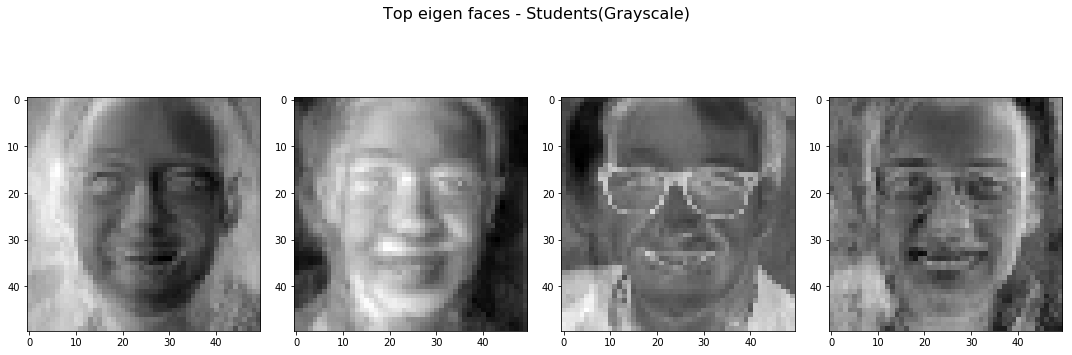

In [437]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6))
for i in range(4):
    axes[i].imshow(imgNorm(eigenFaces_gray[:, i].reshape(50, 50, 3)))
plt.suptitle('Top eigen faces - Faculty(Grayscale)', fontsize=16)
plt.tight_layout()

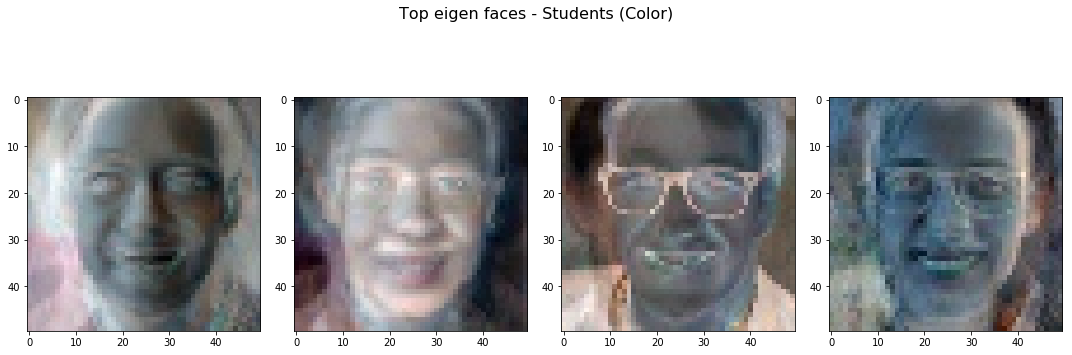

In [438]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6))
for i in range(4):
    axes[i].imshow(imgNorm(eigenFaces_col[:, i].reshape(50, 50, 3)))
plt.suptitle('Top eigen faces - Faculty (Color)', fontsize=16)
plt.tight_layout()

**Explained variance**

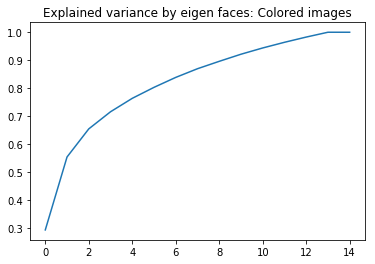

In [439]:
plt.plot(np.cumsum(pca_col.explained_variance_ratio_))
plt.title('Explained variance by eigen faces: Colored images')
plt.show()

In [440]:
print("The first 4 eigen faces explains ",
      str(np.sum(pca_col.explained_variance_ratio_[:4])),
      " of the total variability")

The first 4 eigen faces explains  0.7151921  of the total variability


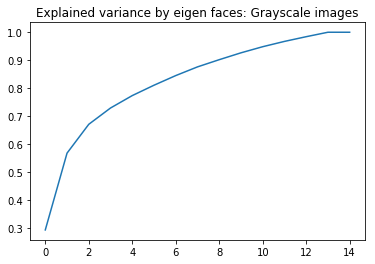

In [441]:
plt.plot(np.cumsum(pca_gray.explained_variance_ratio_))
plt.title('Explained variance by eigen faces: Grayscale images')
plt.show()

In [442]:
print("The first 4 eigen faces explains ",
      str(np.sum(pca_gray.explained_variance_ratio_[:4])),
      " of the total variability")

The first 4 eigen faces explains  0.7293472  of the total variability


**Reconstruction**

In [443]:
myImg = "data/msan-images/faculty-faces_aligned/0_wilson-james.jpg"

In [444]:
img = cv2.imread(myImg)

In [445]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

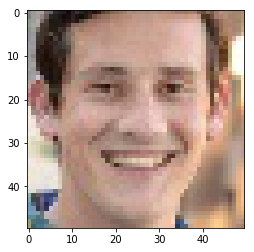

In [446]:
plt.imshow(img)

In [447]:
img_mean_norm = (img.flatten() - avg_col_img.flatten()).reshape(50, 50, 3)

In [449]:
weights = eigfacesCombination(eigenFaces_col, img_mean_norm)

In [453]:
len(weights)

15

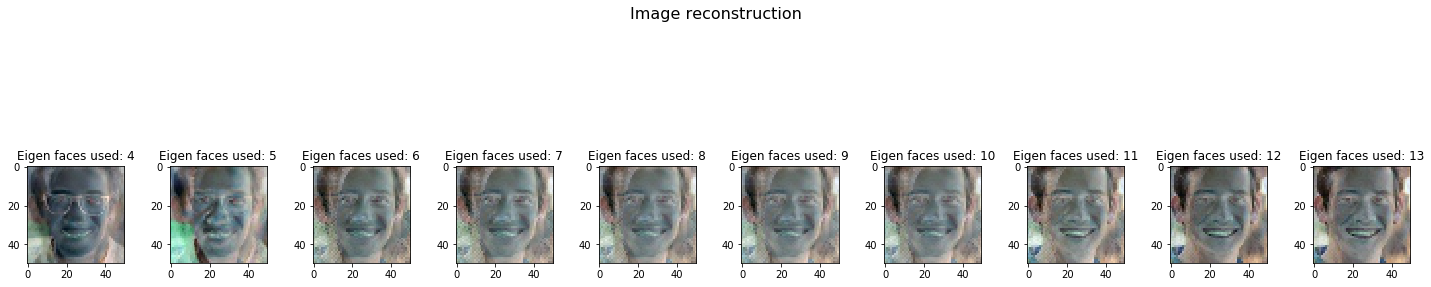

In [457]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 6))
for i in range(10):
    axes[i].imshow(imgNorm(imgReconstruct(eigenFaces_col, weights, i + 4)))
    axes[i].set_title(f"Eigen faces used: {i+4}")
plt.suptitle('Image reconstruction', fontsize=16)
plt.tight_layout()

In [458]:
myImg = "data/msan-images/faculty-faces_aligned/0_parr_terrence.jpg"

In [459]:
img = cv2.imread(myImg)

In [460]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

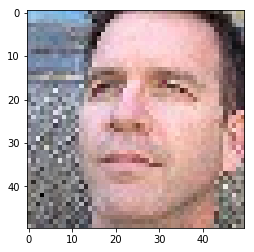

In [461]:
plt.imshow(img)

In [462]:
img_mean_norm = (img.flatten() - avg_col_img.flatten()).reshape(50, 50, 3)

In [464]:
weights = eigfacesCombination(eigenFaces_col, img_mean_norm)

In [465]:
len(weights)

15

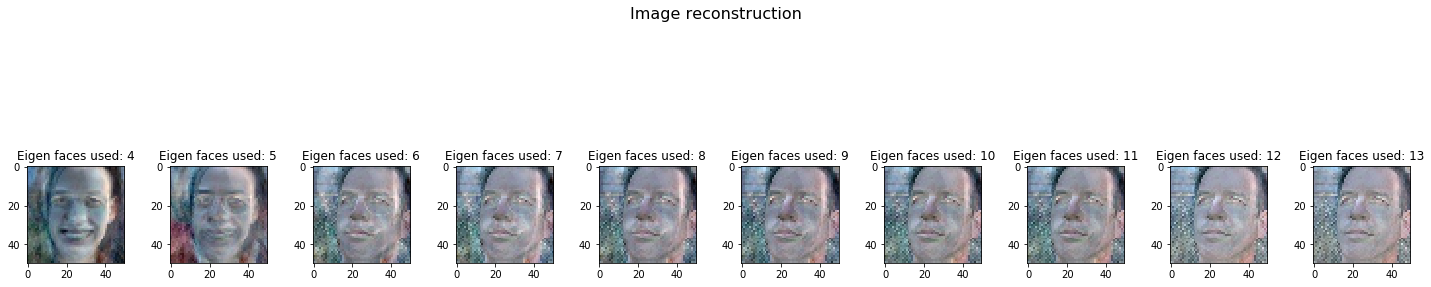

In [467]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 6))
for i in range(10):
    axes[i].imshow(imgNorm(imgReconstruct(eigenFaces_col, weights, i + 4)))
    axes[i].set_title(f"Eigen faces used: {i+4}")
plt.suptitle('Image reconstruction', fontsize=16)
plt.tight_layout()

In [468]:
myImg = "data/msan-images/faculty-faces_aligned/0_woodbridge-diane-03.jpg"

In [469]:
img = cv2.imread(myImg)

In [470]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

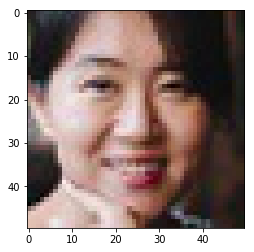

In [471]:
plt.imshow(img)

In [472]:
img_mean_norm = (img.flatten() - avg_col_img.flatten()).reshape(50, 50, 3)

In [474]:
weights = eigfacesCombination(eigenFaces_col, img_mean_norm)

In [475]:
len(weights)

15

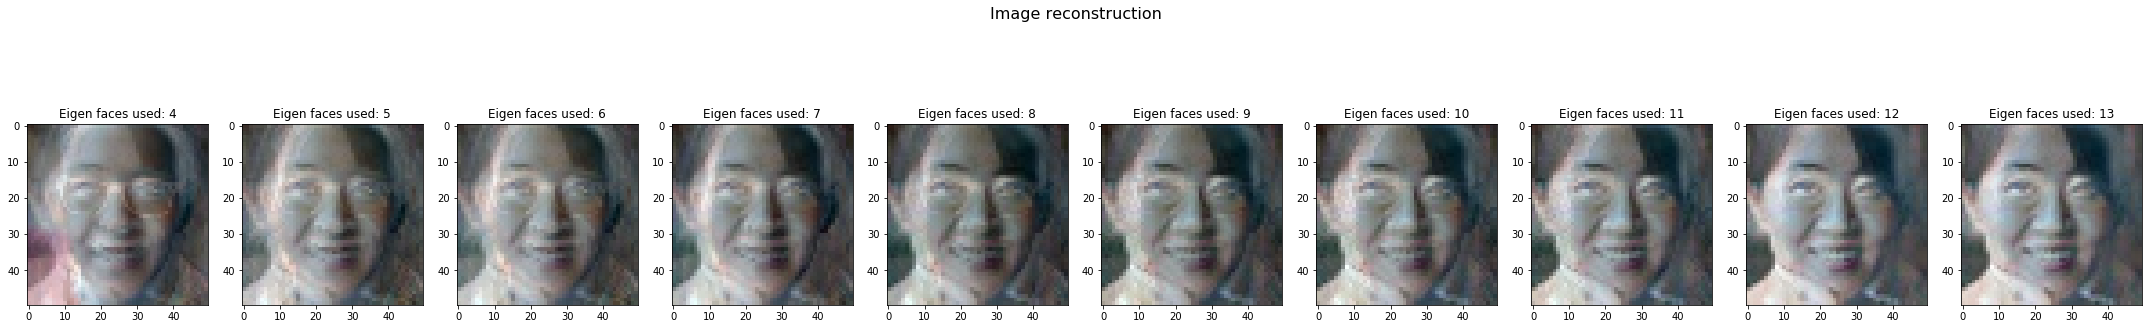

In [479]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(30, 6))
for i in range(10):
    axes[i].imshow(imgNorm(imgReconstruct(eigenFaces_col, weights, i + 4)))
    axes[i].set_title(f"Eigen faces used: {i+4}")
plt.suptitle('Image reconstruction', fontsize=16)
plt.tight_layout()

## Similarity network

In this section we'll try to visulaize the relationship between students and faculty images using networks and understand people who have similar images in terms of their eigenfaces representation

### Students

In [480]:
# Directory containing face images
dirName = "data/msan-images/students-faces-resized/"

stu_fn1 = !ls {path}/students-faces-resized/
# Read images
images = readImages(dirName, stu_fn1)

I'm using grayscale images

In [481]:
#conversion to grayscale
images_gray = [
    np.stack(
        (cv2.cvtColor(i, cv2.COLOR_RGB2GRAY),
         cv2.cvtColor(i, cv2.COLOR_RGB2GRAY),
         cv2.cvtColor(i, cv2.COLOR_RGB2GRAY)),
        axis=-1) for i in images
]

In [482]:
#creating data matrix for pca
data_gray = createDataMatrix(images_gray)

DONE


In [483]:
data_gray = data_gray.T

In [484]:
# finding the average image
avg_gray_img = np.mean(data_gray, axis=1)

In [485]:
# normalizing every image using average image
data_gray_norm = (data_gray - avg_gray_img.reshape(7500, 1))

In [486]:
avg_gray_img = avg_gray_img.reshape(50, 50, 3)

In [489]:
#pca
pca_gray = sklearnPCA()

eigenFaces_gray = pca_gray.fit_transform(data_gray_norm)

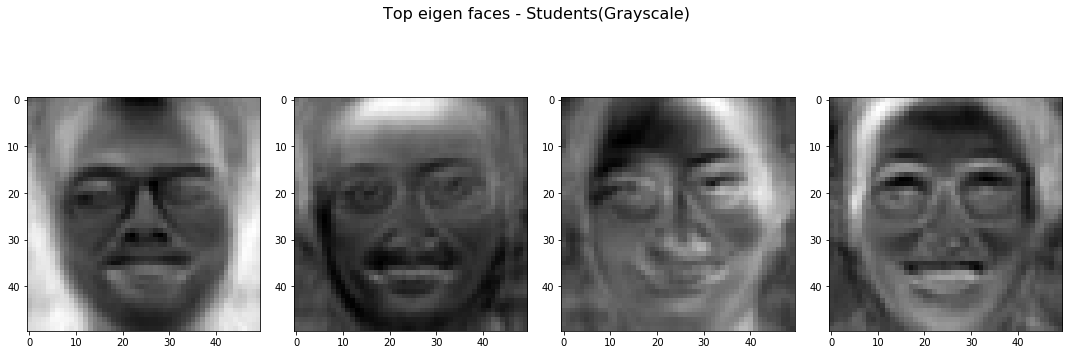

In [490]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6))
for i in range(4):
    axes[i].imshow(imgNorm(eigenFaces_gray[:, i].reshape(50, 50, 3)))
plt.suptitle('Top eigen faces - Students(Grayscale)', fontsize=16)
plt.tight_layout()

**Representation in terms of eigenfaces**

In [731]:
#extracting the name of students
students = ['-'.join(i.split('-')[-2:]) for i in stu_fn1]

students = [s.replace(".jpg", "") for s in students]

In [736]:
student_dict = {}
num_eigfaces = 20  #number of eigenfaces used to reconstruct the original image
for i, s in enumerate(stu_fn1):
    myImg = f"data/msan-images/students-faces-resized/{s}"

    img = cv2.imread(myImg)  # read original image

    img = np.stack(
        (cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
         cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
         cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)),
        axis=-1)  #convert to grayscale

    img_mean_norm = (img.flatten() - avg_gray_img.flatten()).reshape(
        50, 50, 3)  # normalize

    weights = eigfacesCombination(
        eigenFaces_gray, img_mean_norm)  # calculate weights for representation

    student_dict[students[i]] = imgReconstruct(
        eigenFaces_gray, weights, num_eigfaces).flatten()  #reconstruct

In [737]:
df_student = pd.DataFrame.from_dict(student_dict)

In [738]:
df_student.head()

,avgerinou-danai,bowers-devin,campa-ryan,capell-holly,carpenter-jason,chen-liz,chen-si,csiszar-chris,devesh-02,dong-chris,...,wang-jingjue,white-tyler,xu-chengcheng,xu-chuan,xu-zhengjie,yan-dixin,yang-patrick,yue-lan,zhao-yiqiang,zheng-vanessa
0,64.713551,-30.222736,16.838063,27.734434,-17.969742,19.327375,-3.305246,-3.447294,26.592950,24.057726,...,15.476448,-24.188349,-34.161079,-20.675339,-37.590013,45.078682,-3.735708,-12.008227,-31.676830,-10.203780
1,64.713731,-30.222884,16.837883,27.734292,-17.969815,19.327456,-3.304981,-3.447489,26.592988,24.057840,...,15.476615,-24.188425,-34.161159,-20.675254,-37.590096,45.078848,-3.735652,-12.007990,-31.676975,-10.203565
2,64.713667,-30.222803,16.838026,27.734272,-17.969803,19.327375,-3.304973,-3.447625,26.592863,24.057908,...,15.476555,-24.188421,-34.161092,-20.675232,-37.589977,45.078785,-3.735709,-12.008023,-31.676839,-10.203542
3,58.732431,-36.357674,37.287157,30.865436,-24.572512,26.939351,-15.463073,14.111451,30.621664,20.889542,...,23.649171,-6.581790,-56.207101,-23.980038,-35.600859,49.960193,-34.020783,-49.816749,-34.698733,-35.414209
4,58.732498,-36.357502,37.287056,30.864937,-24.572503,26.939216,-15.462944,14.111092,30.621754,20.889774,...,23.649052,-6.581735,-56.206935,-23.979991,-35.600656,49.960173,-34.020766,-49.816470,-34.698557,-35.414040


In [739]:
corr = df_student.corr()  #correlation matrix using representation

In [740]:
corr.head()

,avgerinou-danai,bowers-devin,campa-ryan,capell-holly,carpenter-jason,chen-liz,chen-si,csiszar-chris,devesh-02,dong-chris,...,wang-jingjue,white-tyler,xu-chengcheng,xu-chuan,xu-zhengjie,yan-dixin,yang-patrick,yue-lan,zhao-yiqiang,zheng-vanessa
avgerinou-danai,1.000000,-0.289831,-0.226547,-0.012014,-0.128856,0.285953,0.564833,-0.630893,-0.137189,0.378196,...,0.419875,-0.253720,-0.354800,0.086771,-0.339558,0.632727,0.296836,0.605618,-0.371200,0.423747
bowers-devin,-0.289831,1.000000,0.228092,-0.150683,0.428435,-0.349909,-0.165946,-0.168451,0.422821,0.114951,...,-0.540995,0.568304,0.164969,-0.212835,-0.017344,-0.486906,-0.135943,-0.347327,0.349288,-0.599100
campa-ryan,-0.226547,0.228092,1.000000,0.007953,0.174900,-0.175520,-0.415564,0.217818,0.529919,0.417258,...,-0.501711,0.178025,-0.243580,-0.053653,0.211840,-0.497900,-0.497971,-0.415198,0.363266,-0.436412
capell-holly,-0.012014,-0.150683,0.007953,1.000000,-0.188459,0.228402,-0.299097,0.216903,-0.232782,-0.087948,...,0.092899,-0.189283,-0.074827,0.046597,-0.288225,0.050698,0.002959,-0.333535,-0.243185,-0.050332
carpenter-jason,-0.128856,0.428435,0.174900,-0.188459,1.000000,-0.368539,0.080336,-0.006384,0.361301,-0.206108,...,-0.054215,0.287968,-0.281905,-0.041151,-0.170667,-0.128850,-0.482276,0.032204,-0.309117,-0.119215


In [741]:
links = corr.stack().reset_index()

In [742]:
links.columns = ['student1', 'student2', 'correlation']

In [743]:
links.head()

,student1,student2,correlation
0,avgerinou-danai,avgerinou-danai,1.000000
1,avgerinou-danai,bowers-devin,-0.289831
2,avgerinou-danai,campa-ryan,-0.226547
3,avgerinou-danai,capell-holly,-0.012014
4,avgerinou-danai,carpenter-jason,-0.128856


In [744]:
# cosine similarity
links['cosine'] = links.apply(
    lambda x: 1 - distance.cosine(df_student[x['student1']], df_student[x['student2']]),
    axis=1)

In [749]:
# apply a threshold on cosine similarity to find the faces which are most similar
links_filtered = links.loc[(links['cosine'] > 0.80)
                           & (links['student1'] != links['student2'])]

In [750]:
links_filtered

,student1,student2,correlation,cosine
478,chen-si,li-qian,0.803304,0.803304
565,csiszar-chris,pellerin-taylor,0.822768,0.822768
941,feiran-02,peng-tina,0.808611,0.808611
2106,li-qian,chen-si,0.803304,0.803304
2170,li-qian,yan-dixin,0.857348,0.857348
2587,logan-savannah,mcnish-shannon,0.803799,0.803799
2809,mcnish-shannon,logan-savannah,0.803799,0.803799
3007,pellerin-taylor,csiszar-chris,0.822768,0.822768
3087,peng-tina,feiran-02,0.808611,0.808611
3435,savage-danielle,tollas-kaya,0.864706,0.864706


In [751]:
# creating a network
G = nx.from_pandas_edgelist(links_filtered, 'student1', 'student2')

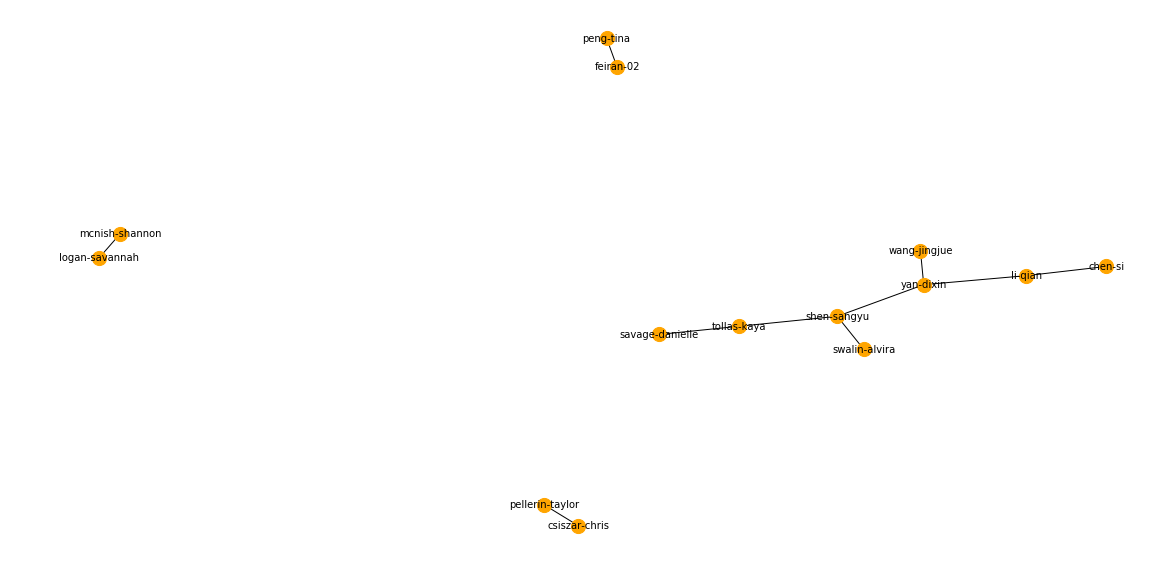

In [752]:
# visualizing the network
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
nx.draw(
    G,
    with_labels=True,
    node_color='orange',
    node_size=200,
    edge_color='black',
    linewidths=1,
    font_size=10,
    ax=axes,
    pos=nx.fruchterman_reingold_layout(G))

**Maximum cosine similarity for each student**

In [753]:
links_filtered = links.loc[(links['student1'] != links['student2'])]

In [754]:
links_filtered.shape

(5550, 4)

In [755]:
links_max_similarity = links_filtered.loc[links_filtered.groupby('student1')['cosine'].transform(max) == links_filtered['cosine']]

In [757]:
# creating a network
G = nx.from_pandas_edgelist(links_max_similarity, 'student1', 'student2')

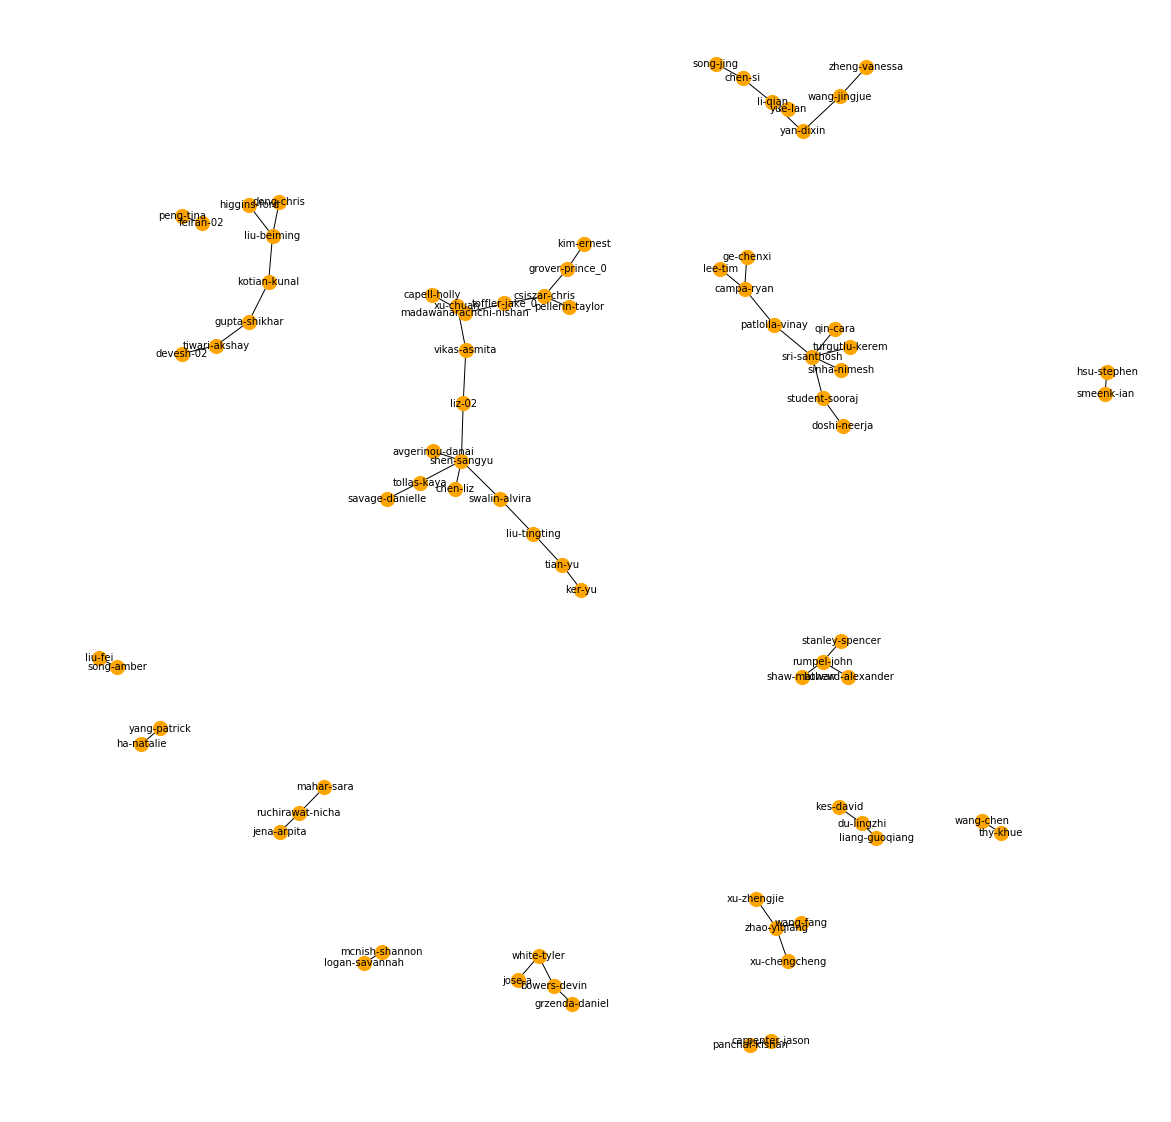

In [758]:
# visualizing the network
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
nx.draw(
    G,
    with_labels=True,
    node_color='orange',
    node_size=200,
    edge_color='black',
    linewidths=1,
    font_size=10,
    ax=axes,
    pos=nx.fruchterman_reingold_layout(G))

### Students + Faculty

In [777]:
# Directory containing face images
dirName = "data/msan-images/combined/"

com_fn = !ls {path}/combined/
# Read images
images = readImages(dirName, com_fn)

I'm using grayscale images

In [778]:
#conversion to grayscale
images_gray = [
    np.stack(
        (cv2.cvtColor(i, cv2.COLOR_RGB2GRAY),
         cv2.cvtColor(i, cv2.COLOR_RGB2GRAY),
         cv2.cvtColor(i, cv2.COLOR_RGB2GRAY)),
        axis=-1) for i in images
]

In [779]:
#creating data matrix for pca
data_gray = createDataMatrix(images_gray)

DONE


In [780]:
data_gray = data_gray.T

In [781]:
# finding the average image
avg_gray_img = np.mean(data_gray, axis=1)

In [782]:
# normalizing every image using average image
data_gray_norm = (data_gray - avg_gray_img.reshape(7500, 1))

In [783]:
avg_gray_img = avg_gray_img.reshape(50, 50, 3)

In [784]:
#pca
pca_gray = sklearnPCA()

eigenFaces_gray = pca_gray.fit_transform(data_gray_norm)

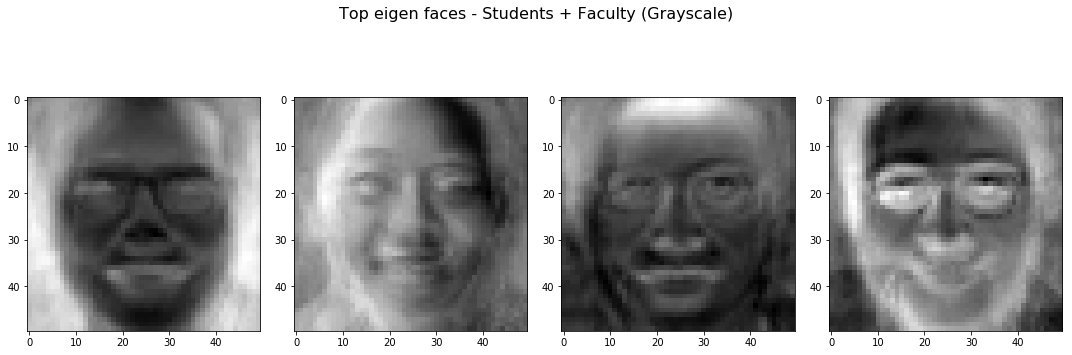

In [785]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6))
for i in range(4):
    axes[i].imshow(imgNorm(eigenFaces_gray[:, i].reshape(50, 50, 3)))
plt.suptitle('Top eigen faces - Students + Faculty (Grayscale)', fontsize=16)
plt.tight_layout()

**Representation in terms of eigenfaces**

In [787]:
#extracting the name of students
name = ['-'.join(i.split('-')[-2:]) for i in com_fn]

In [789]:
name = [s.replace(".jpg", "") for s in name]

In [812]:
person_dict = {}
num_eigfaces = 30  #number of eigenfaces used to reconstruct the original image
for i, s in enumerate(com_fn):
    myImg = f"data/msan-images/combined/{s}"

    img = cv2.imread(myImg)  # read original image

    img = np.stack(
        (cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
         cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
         cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)),
        axis=-1)  #convert to grayscale

    img_mean_norm = (img.flatten() - avg_gray_img.flatten()).reshape(
        50, 50, 3)  # normalize

    weights = eigfacesCombination(
        eigenFaces_gray, img_mean_norm)  # calculate weights for representation

    person_dict[name[i]] = imgReconstruct(eigenFaces_gray, weights,
                                          num_eigfaces).flatten()  #reconstruct

In [813]:
df_combined = pd.DataFrame.from_dict(person_dict)

In [814]:
df_combined.head()

,0_engle_sophie,0_francis-lyon_patricia,0_hamrick-jeff1,0_interian-yannet,0_intrevado-paul,0_nick-ross,0_parr_terrence,0_stevens-nathaniel,0_thomas-rachel,0_u_devlin,...,wang-jingjue,white-tyler,xu-chengcheng,xu-chuan,xu-zhengjie,yan-dixin,yang-patrick,yue-lan,zhao-yiqiang,zheng-vanessa
0,-9.763544,-28.681896,85.057841,-52.496723,11.316355,78.554839,13.001888,79.406127,-10.611259,-29.638792,...,2.277461,-16.333391,-30.184927,-12.095304,-43.698698,48.253435,-16.799408,-15.415875,-22.592037,-25.659826
1,-9.763439,-28.681740,85.057989,-52.496512,11.316481,78.555190,13.002034,79.406383,-10.611268,-29.638585,...,2.277425,-16.333300,-30.184981,-12.095287,-43.698869,48.253292,-16.799404,-15.416076,-22.592154,-25.660047
2,-9.763660,-28.681903,85.057681,-52.496606,11.316472,78.555031,13.001849,79.406112,-10.611436,-29.638620,...,2.277584,-16.333357,-30.184952,-12.095289,-43.698832,48.253381,-16.799478,-15.415899,-22.592178,-25.659856
3,7.328948,-42.008989,101.189828,-59.016126,17.120456,99.127942,30.774307,83.696645,17.168034,-18.650452,...,19.138487,-3.726622,-60.422853,-27.208357,-43.303505,47.935428,-60.785851,-52.286721,-21.858630,-57.118052
4,7.328948,-42.008985,101.189736,-59.015982,17.120687,99.127801,30.774314,83.696681,17.168216,-18.650551,...,19.138452,-3.726514,-60.422759,-27.208344,-43.303556,47.935291,-60.785962,-52.286770,-21.858615,-57.118225


In [815]:
corr = df_combined.corr()  #correlation matrix using representation

In [816]:
corr.head()

,0_engle_sophie,0_francis-lyon_patricia,0_hamrick-jeff1,0_interian-yannet,0_intrevado-paul,0_nick-ross,0_parr_terrence,0_stevens-nathaniel,0_thomas-rachel,0_u_devlin,...,wang-jingjue,white-tyler,xu-chengcheng,xu-chuan,xu-zhengjie,yan-dixin,yang-patrick,yue-lan,zhao-yiqiang,zheng-vanessa
0_engle_sophie,1.000000,0.097168,0.509247,-0.075821,0.341195,0.374107,0.471931,0.205172,0.500156,-0.051030,...,-0.426121,0.078362,0.252901,0.043143,0.034363,-0.285432,-0.065809,-0.314800,0.283323,-0.327639
0_francis-lyon_patricia,0.097168,1.000000,0.077768,0.555129,-0.177016,-0.033207,0.142765,-0.034161,0.240106,0.188931,...,0.188094,-0.204924,0.186406,-0.008332,-0.020883,0.005748,0.167294,-0.054186,-0.052785,-0.089325
0_hamrick-jeff1,0.509247,0.077768,1.000000,-0.439011,0.548175,0.658917,0.272494,0.147818,-0.057404,0.181095,...,-0.503800,0.240636,0.084002,-0.202764,0.192740,-0.463262,-0.433803,-0.601811,0.309056,-0.561517
0_interian-yannet,-0.075821,0.555129,-0.439011,1.000000,-0.496170,-0.434089,0.038259,-0.112094,0.407391,-0.065533,...,0.497851,-0.353479,0.100808,0.232643,-0.169984,0.414678,0.315432,0.459850,-0.268477,0.244835
0_intrevado-paul,0.341195,-0.177016,0.548175,-0.496170,1.000000,0.696923,0.460784,0.459972,-0.194006,0.401231,...,-0.540427,0.189228,0.141348,-0.313280,-0.028657,-0.666185,-0.366498,-0.528065,0.162977,-0.487975


In [817]:
links = corr.stack().reset_index()

In [818]:
links.columns = ['p1', 'p2', 'correlation']

In [819]:
links.head()

,p1,p2,correlation
0,0_engle_sophie,0_engle_sophie,1.000000
1,0_engle_sophie,0_francis-lyon_patricia,0.097168
2,0_engle_sophie,0_hamrick-jeff1,0.509247
3,0_engle_sophie,0_interian-yannet,-0.075821
4,0_engle_sophie,0_intrevado-paul,0.341195


In [820]:
# cosine similarity
links['cosine'] = links.apply(
    lambda x: 1 - distance.cosine(df_combined[x['p1']], df_combined[x['p2']]),
    axis=1)

**Maximum cosine similarity for each pair**

In [821]:
links_filtered = links.loc[(links['p1'] != links['p2'])]

In [822]:
links_filtered.shape

(8010, 4)

In [823]:
links_max_similarity = links_filtered.loc[links_filtered.groupby('p1')[
    'cosine'].transform(max) == links_filtered['cosine']]

In [824]:
# creating a network
G = nx.from_pandas_edgelist(links_max_similarity, 'p1', 'p2')

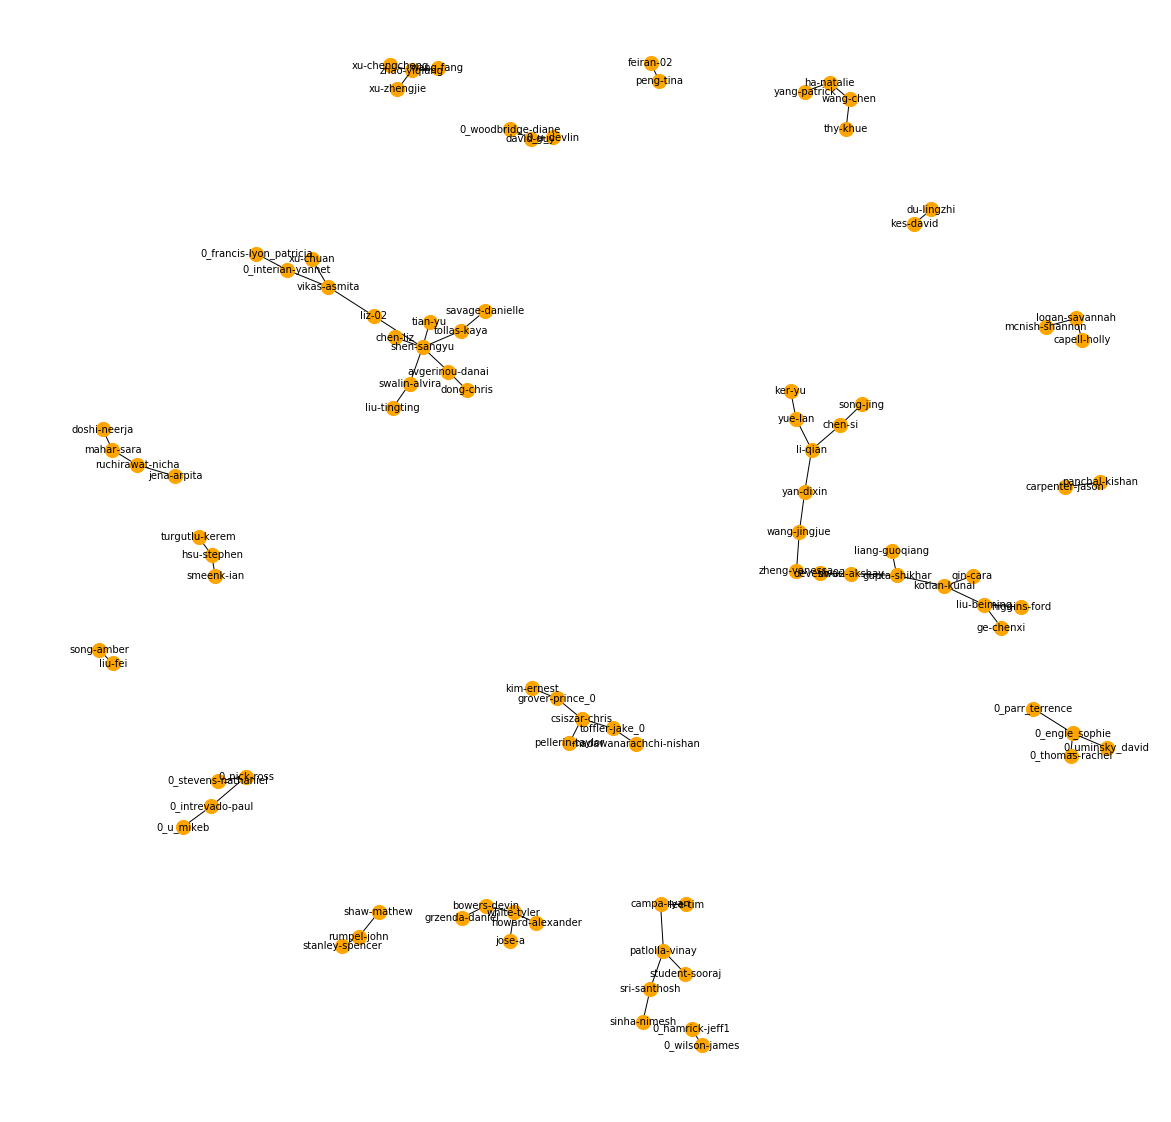

In [825]:
# visualizing the network
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
nx.draw(
    G,
    with_labels=True,
    node_color='orange',
    node_size=200,
    edge_color='black',
    linewidths=1,
    font_size=10,
    ax=axes,
    pos=nx.fruchterman_reingold_layout(G))

In [826]:
links_filtered.p1.unique()

array(['0_engle_sophie', '0_francis-lyon_patricia', '0_hamrick-jeff1',
       '0_interian-yannet', '0_intrevado-paul', '0_nick-ross',
       '0_parr_terrence', '0_stevens-nathaniel', '0_thomas-rachel',
       '0_u_devlin', '0_u_mikeb', '0_uminsky_david', '0_wilson-james',
       '0_woodbridge-diane', 'avgerinou-danai', 'bowers-devin',
       'campa-ryan', 'capell-holly', 'carpenter-jason', 'chen-liz',
       'chen-si', 'csiszar-chris', 'david-guy', 'devesh-02', 'dong-chris',
       'doshi-neerja', 'du-lingzhi', 'feiran-02', 'ge-chenxi',
       'grover-prince_0', 'grzenda-daniel', 'gupta-shikhar', 'ha-natalie',
       'higgins-ford', 'howard-alexander', 'hsu-stephen', 'jena-arpita',
       'jose-a', 'ker-yu', 'kes-david', 'kim-ernest', 'kotian-kunal',
       'lee-tim', 'li-qian', 'liang-guoqiang', 'liu-beiming', 'liu-fei',
       'liu-tingting', 'liz-02', 'logan-savannah',
       'madawanarachchi-nishan', 'mahar-sara', 'mcnish-shannon',
       'panchal-kishan', 'patlolla-vinay', 'peller

In [827]:
links_similarity_james = links_filtered.loc[links_filtered.p1 ==
                                            '0_wilson-james']

In [828]:
links_similarity_james.sort_values('cosine', ascending=False)

,p1,p2,correlation,cosine
1082,0_wilson-james,0_hamrick-jeff1,0.687815,0.687815
1084,0_wilson-james,0_intrevado-paul,0.574935,0.574935
1149,0_wilson-james,student-sooraj,0.550525,0.550525
1085,0_wilson-james,0_nick-ross,0.516407,0.516407
1147,0_wilson-james,sri-santhosh,0.490158,0.490158
1134,0_wilson-james,patlolla-vinay,0.483645,0.483645
1091,0_wilson-james,0_uminsky_david,0.471249,0.471249
1159,0_wilson-james,wang-fang,0.459550,0.459550
1080,0_wilson-james,0_engle_sophie,0.454129,0.454129
1119,0_wilson-james,kes-david,0.364353,0.364353


James your face is most similar to `Jeff Hamrick`

Let's see why

**James**

In [ ]:
myImg = "data/msan-images/combined/0_wilson-james.jpg"

In [839]:
myImg1 = "data/msan-images/combined/0_hamrick-jeff1.jpg"

In [840]:
img = cv2.imread(myImg)

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img = np.stack((img, img, img), axis=-1)

In [842]:
img1 = cv2.imread(myImg1)

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

img1 = np.stack((img1, img1, img1), axis=-1)

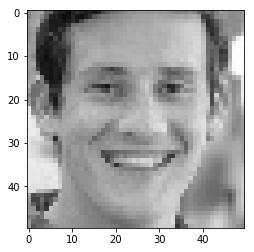

In [843]:
plt.imshow(img)

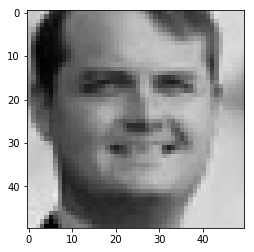

In [844]:
plt.imshow(img1)

In [848]:
img_mean_norm = (img.flatten() - avg_gray_img.flatten()).reshape(50, 50, 3)

weights = eigfacesCombination(eigenFaces_gray, img_mean_norm)

In [849]:
img1_mean_norm = (img1.flatten() - avg_gray_img.flatten()).reshape(50, 50, 3)

weights1 = eigfacesCombination(eigenFaces_gray, img1_mean_norm)

In [850]:
len(weights)

90

In [851]:
len(weights1)

90

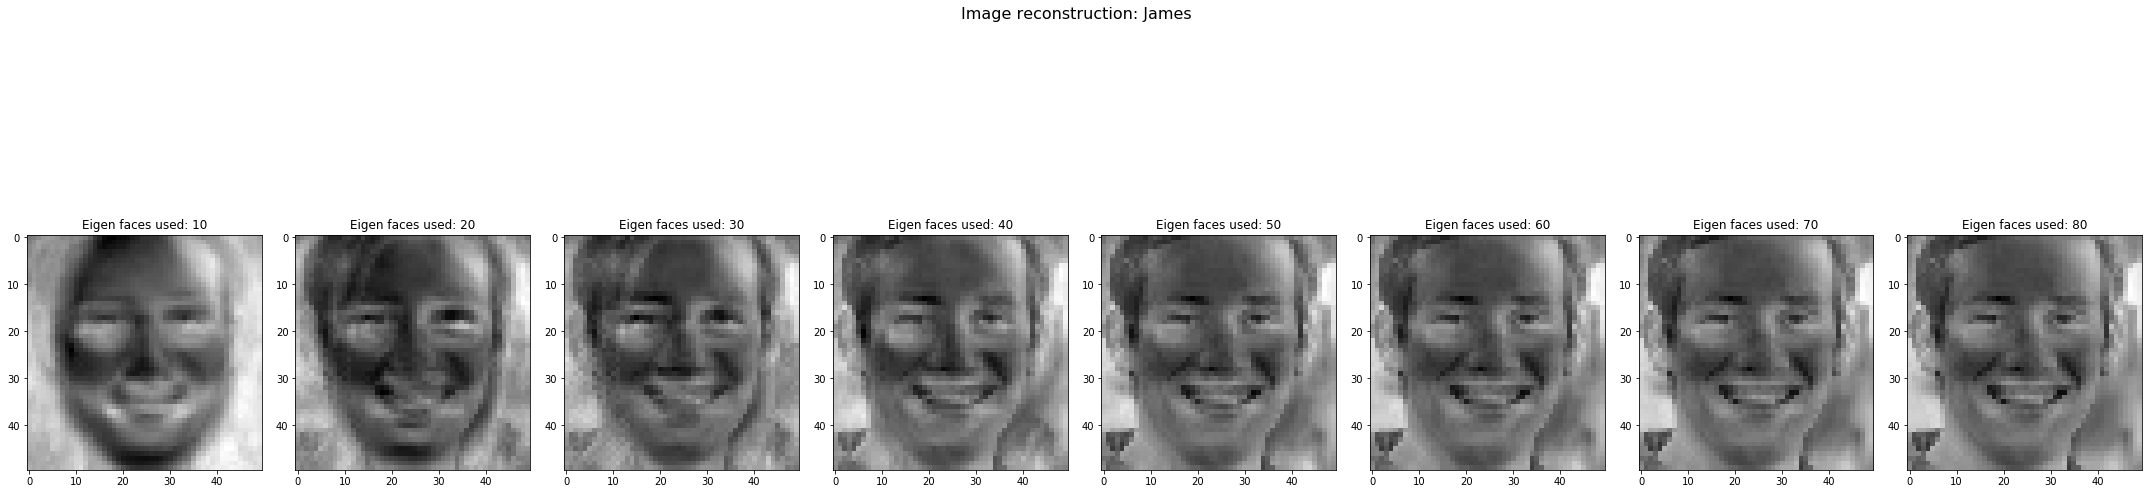

In [857]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(30, 10))
for i in range(8):
    axes[i].imshow(
        imgNorm(imgReconstruct(eigenFaces_gray, weights, 10 * (i + 1))))
    axes[i].set_title(f"Eigen faces used: {10 * (i + 1)}")
plt.suptitle('Image reconstruction: James', fontsize=16)
plt.tight_layout()

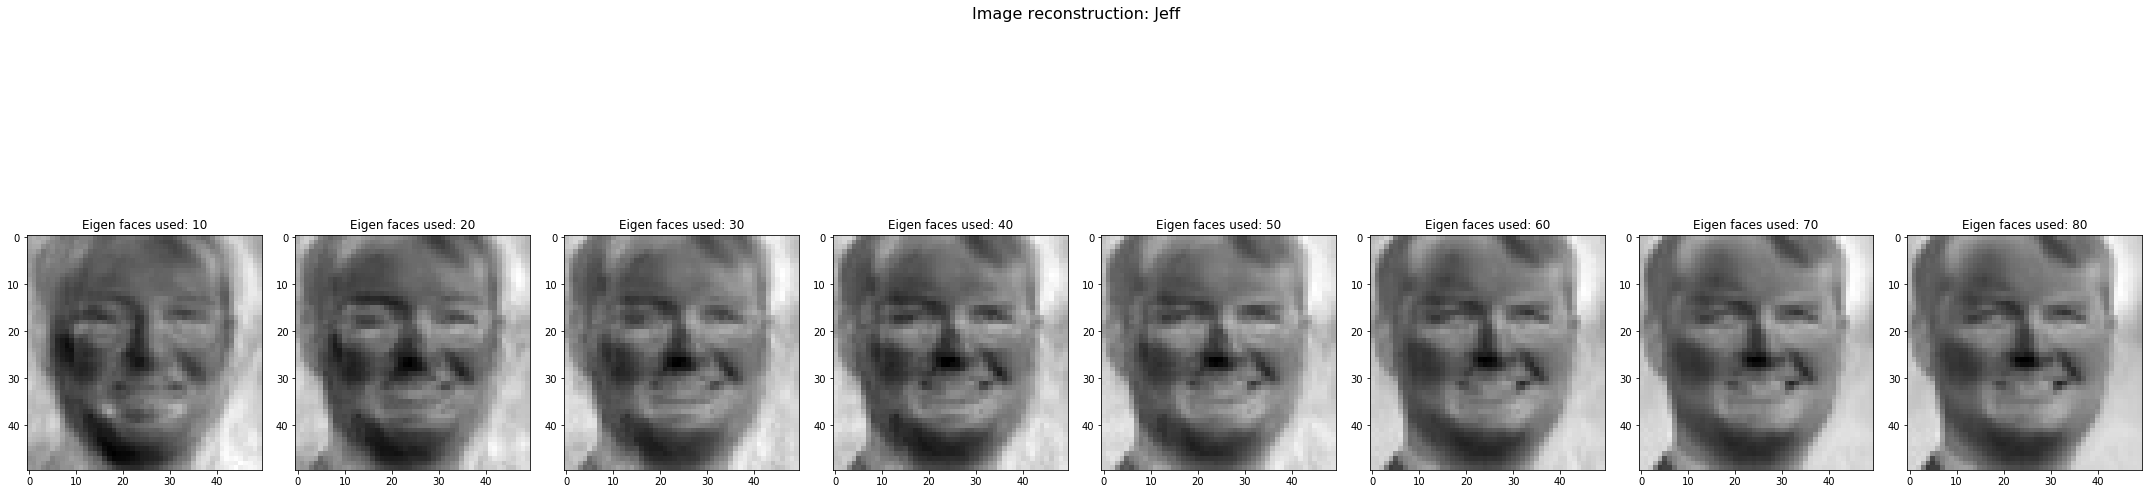

In [858]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(30, 10))
for i in range(8):
    axes[i].imshow(
        imgNorm(imgReconstruct(eigenFaces_gray, weights1, 10 * (i + 1))))
    axes[i].set_title(f"Eigen faces used: {10 * (i + 1)}")
plt.suptitle('Image reconstruction: Jeff', fontsize=16)
plt.tight_layout()